# Tarea 1 DAML Prueba 2
### Joaquín Araena Uribe
### 2021454110


In [87]:
#Importamos las librerias

import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt  
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
from statsmodels.iolib.summary2 import summary_col
import time as time

sns.set_palette("muted")

In [88]:
#Funciones a utilizar

def cardinales(x):
    if x[0] == "N":
        return("N")
    elif x[0] == "S":
        return("S")
    elif x[0] == "E":
        return("E")
    else:
        return("W")

### Parte 1

#### Tratamiento de datos

In [89]:
df = pd.read_csv("machine_failure_data.csv") #Leemos el dataframe
df["Failure_today"] = df["Failure_today"].apply(lambda x: 0 if x == "No" else 1) #Modificamos la variable a binaria
#df["Leakage"] = df["Leakage"].apply(lambda x: 0 if x == 0 else 1)

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y") #Aplicamos arreglo a las fechas
df = df[~df["Date"].dt.year.isin([2007,2008,2009])]
df["Date"] = df["Date"].dt.date
df["Date"] = df["Date"].astype(str)

df["Fecha"] = pd.to_datetime(df["Date"])
df["Año"] = df["Fecha"].dt.year.apply(str)
df["Mes"] = df["Fecha"].dt.month
#df["Trimestre"] = df["Mes"].apply(lambda x: f"T{((x - 1) // 3) + 1}")
df["Mes"] = df["Mes"].apply(str)

#df["Electricity"] = df["Electricity"].fillna(0)
#df["Evaporation"] = df["Evaporation"].fillna(0)
#df["Electricity_NaN"] = df["Electricity"].isna().astype(int)
#df["Evaporation_NaN"] = df["Evaporation"].isna().astype(int)

df_mask = df[(df["Location"] == 17) | (df["Location"] == 26) | (df["Location"] == 42)| (df["Location"] == 46)| (df["Location"] == 19)] #Eliminamos años con pocos datos
df_filtrado = df.drop(df_mask.index)
df = df_filtrado.reset_index(drop=True)

df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Fecha,Año,Mes
0,2010-01-01,3,19.4,31.9,5.0,NaN,NaN,NNE,39.0,NW,...,1012.2,1008.5,NaN,1.0,23.4,30.9,1,2010-01-01,2010,1
1,2010-01-02,3,18.6,29.1,12.4,NaN,NaN,W,56.0,S,...,1007.8,1006.2,5.0,NaN,20.6,28.0,1,2010-01-02,2010,1
2,2010-01-03,3,12.2,29.7,0.0,NaN,NaN,W,30.0,SSW,...,1014.4,1012.5,NaN,NaN,18.0,28.0,0,2010-01-03,2010,1
3,2010-01-04,3,14.8,32.8,0.0,NaN,NaN,SW,30.0,ENE,...,1017.5,1013.6,NaN,NaN,21.3,30.6,0,2010-01-04,2010,1
4,2010-01-05,3,15.0,35.8,0.0,NaN,NaN,W,46.0,E,...,1014.9,1011.5,NaN,NaN,23.3,34.9,0,2010-01-05,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114562,2017-06-20,14,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,...,1013.9,1010.5,0.0,1.0,24.5,32.3,0,2017-06-20,2017,6
114563,2017-06-21,14,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,...,1014.6,1011.2,7.0,0.0,24.8,32.0,0,2017-06-21,2017,6
114564,2017-06-22,14,20.7,32.8,0.0,5.6,11.0,E,33.0,E,...,1015.3,1011.8,0.0,0.0,24.8,32.1,0,2017-06-22,2017,6
114565,2017-06-23,14,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,...,1014.9,1010.7,1.0,1.0,24.8,29.2,0,2017-06-23,2017,6


In [90]:
#Eliminamos columnas que no vamos a ocupar

df = df.drop(columns=["Electricity", #Muchos NaN
                      
                      "Evaporation", #Muchos NaN
                      "Leakage",
                      "Parameter6_9am",
                      "Parameter6_3pm",
                      "Parameter1_Dir"
                      #"Parameter2_9am",
                      #"Parameter2_3pm"
                      ]
)

#Eliminamos datos faltantes
df.dropna(inplace=True)
#df["Parameter1_Dir"] = df["Parameter1_Dir"].apply(cardinales)
df["Parameter2_9am"] = df["Parameter2_9am"].apply(cardinales) #Aplicamos funcion para direcciones cardinales
df["Parameter2_3pm"] = df["Parameter2_3pm"].apply(cardinales)
df = df.reset_index(drop=True)

In [91]:
df #Dataframe limpio

,Date,Location,Min_Temp,Max_Temp,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Fecha,Año,Mes
0,2010-01-01,3,19.4,31.9,39.0,N,W,9.0,9.0,70.0,40.0,1012.2,1008.5,23.4,30.9,1,2010-01-01,2010,1
1,2010-01-02,3,18.6,29.1,56.0,S,W,6.0,28.0,88.0,48.0,1007.8,1006.2,20.6,28.0,1,2010-01-02,2010,1
2,2010-01-03,3,12.2,29.7,30.0,S,S,9.0,19.0,57.0,32.0,1014.4,1012.5,18.0,28.0,0,2010-01-03,2010,1
3,2010-01-04,3,14.8,32.8,30.0,E,N,11.0,9.0,55.0,24.0,1017.5,1013.6,21.3,30.6,0,2010-01-04,2010,1
4,2010-01-05,3,15.0,35.8,46.0,E,N,4.0,17.0,46.0,13.0,1014.9,1011.5,23.3,34.9,0,2010-01-05,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91384,2017-06-20,14,19.3,33.4,35.0,S,N,9.0,20.0,63.0,32.0,1013.9,1010.5,24.5,32.3,0,2017-06-20,2017,6
91385,2017-06-21,14,21.2,32.6,37.0,S,S,13.0,11.0,56.0,28.0,1014.6,1011.2,24.8,32.0,0,2017-06-21,2017,6
91386,2017-06-22,14,20.7,32.8,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,24.8,32.1,0,2017-06-22,2017,6
91387,2017-06-23,14,19.5,31.8,26.0,S,N,9.0,17.0,62.0,58.0,1014.9,1010.7,24.8,29.2,0,2017-06-23,2017,6


#### Gráficos

<Axes: xlabel='Failure_today', ylabel='Max_Temp'>

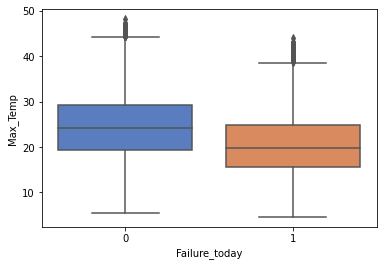

In [107]:
sns.boxplot(df,x="Failure_today",y="Max_Temp")

podemos ver que, cuando la maquina falla, su max_temp está centrada en una menor que cuando no falla

<Axes: title={'center': 'Max_temp cuando no falla (Superior) vs cuando falla (inferior)'}, xlabel='Max_Temp', ylabel='Count'>

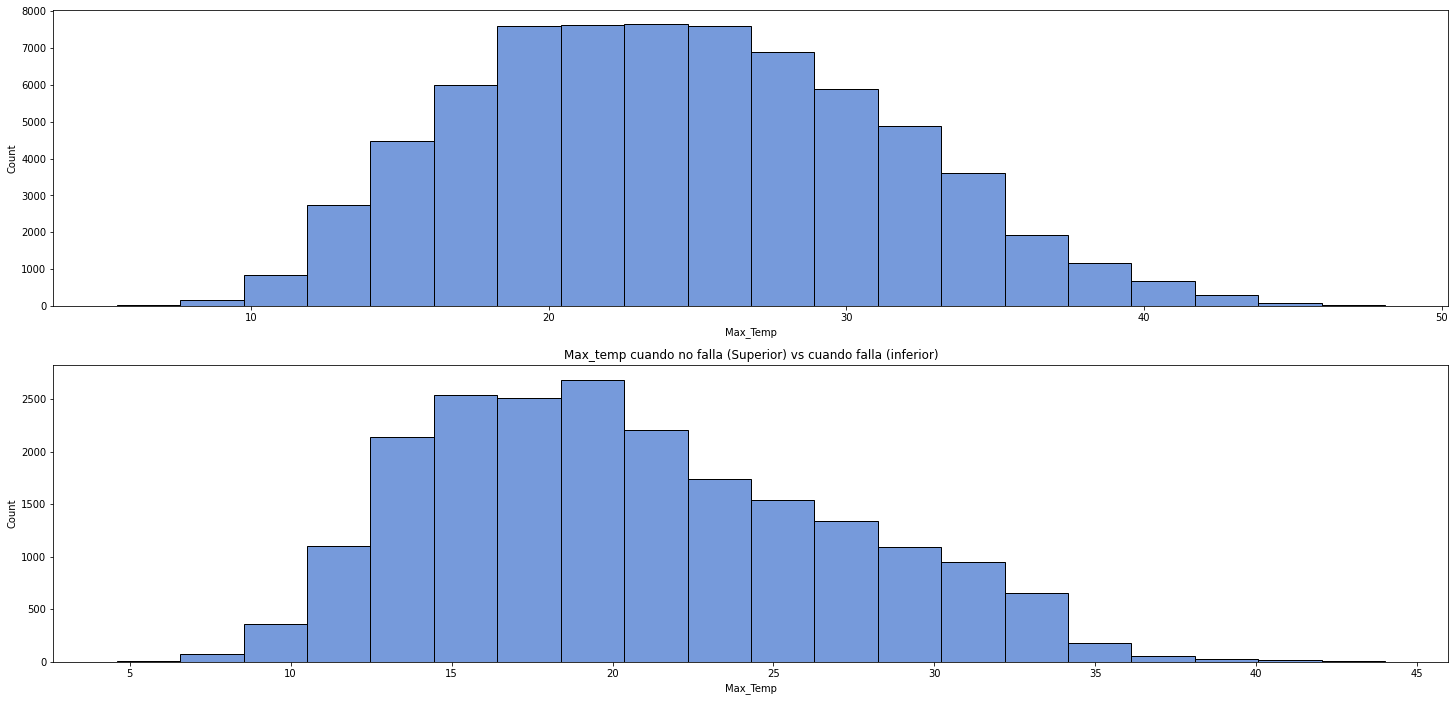

In [130]:
fig, axes = plt.subplots(2, 1, figsize=(25, 12))
plt.title("Max_temp cuando no falla (Superior) vs cuando falla (inferior)")
sns.histplot(data=df[df["Failure_today"] == 0],x="Max_Temp",bins=20,ax=axes[0])
sns.histplot(data=df[df["Failure_today"] == 1],x="Max_Temp",bins=20,ax=axes[1])

Este histograma nos entrega información diferenciada sobre la temperatura máxima en los casos que el sensor detectó un fallo y en los que no. Si bien se distribuyen de forma similar, podemos ver una leve diferencia en la forma, lo cual corrobora lo visto en el boxplot

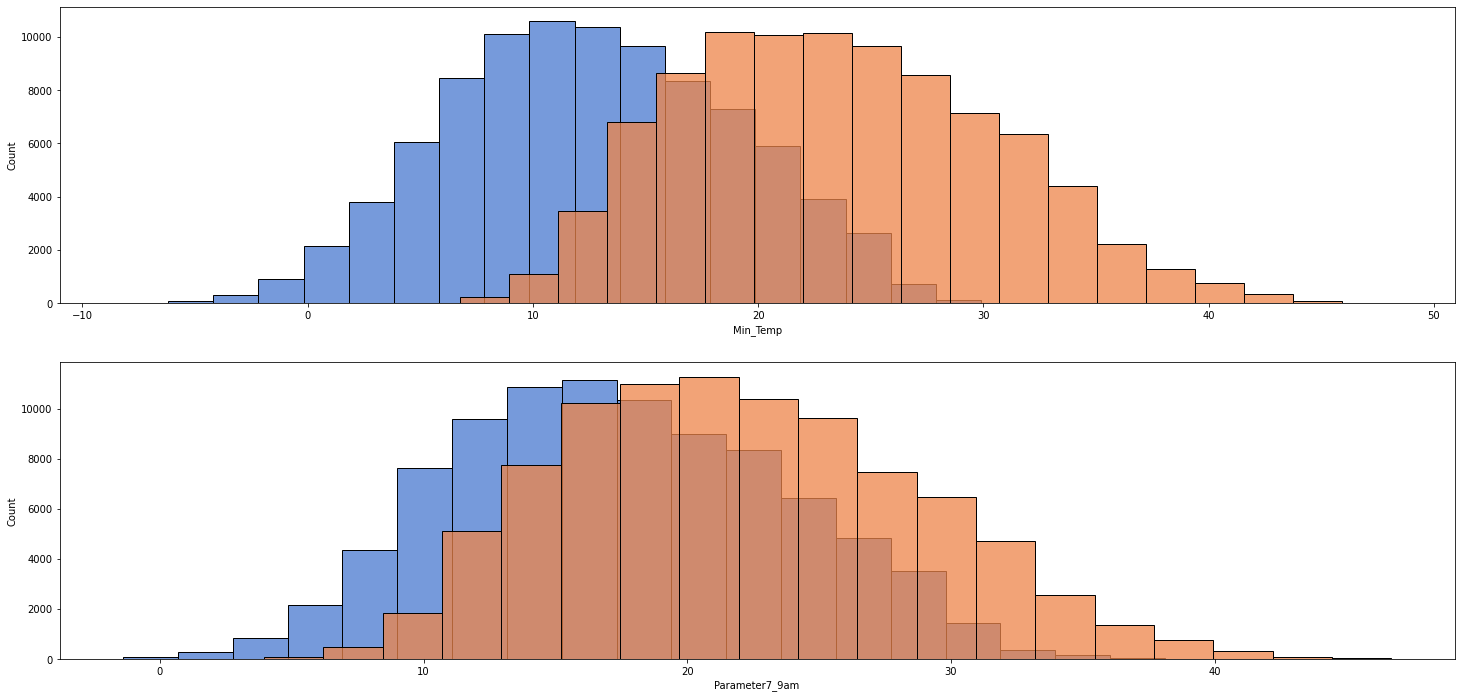

In [93]:
fig, axes = plt.subplots(2, 1, figsize=(25, 12))
sns.histplot(data=df,x="Min_Temp",bins=20,ax=axes[0])
sns.histplot(data=df,x="Max_Temp",bins=20,ax=axes[0])
sns.histplot(data=df,x="Parameter7_9am",bins=20,ax=axes[1])
sns.histplot(data=df,x="Parameter7_3pm",bins=20,ax=axes[1])
plt.show()

Siguiendo con las temperaturas, nos interesa ver la relación de la temperatura maxima con la minima, y podemos notar que tanto en el parametro 7 como en la variable que mide esta se aprecia un comportamiento similar entre las 2 medidas

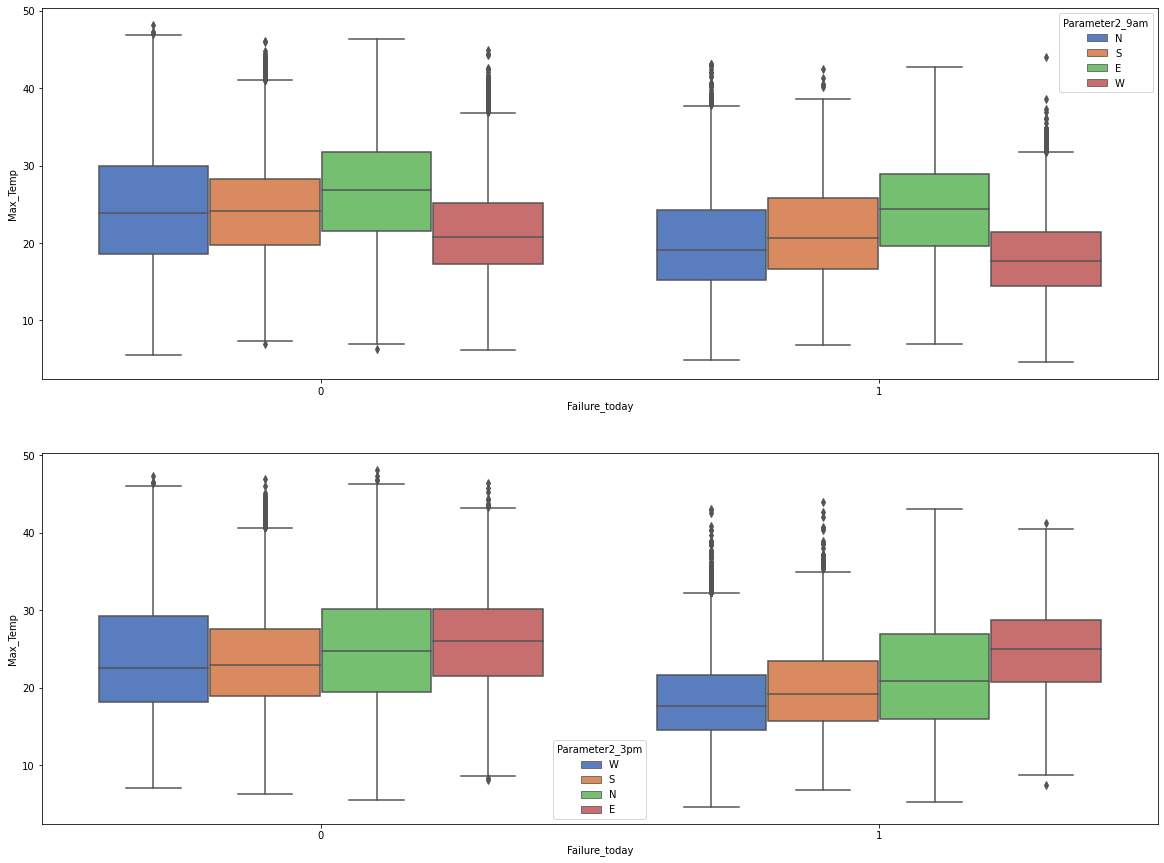

In [94]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
sns.boxplot(data=df, y="Max_Temp", x="Failure_today",hue="Parameter2_9am",ax=axes[0])
sns.boxplot(data=df, y="Max_Temp", x="Failure_today",hue="Parameter2_3pm",ax=axes[1])
plt.show()



La principal diferencia la podemos encontrar a las 3pm cuando la dirección del viento corre hacia el Oeste. Para interpretar de mejor manera el fenomeno, se hace un histograma

<Axes: xlabel='Max_Temp', ylabel='Density'>

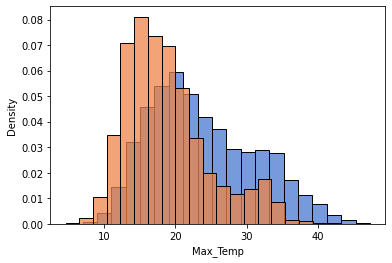

In [95]:
sns.histplot(data=df[(df["Parameter2_3pm"] == "W") & (df["Failure_today"] == 0)],x="Max_Temp",stat="density",bins=20)
sns.histplot(data=df[(df["Parameter2_3pm"] == "W") & (df["Failure_today"] == 1)],x="Max_Temp",stat="density",bins=20)


Podemos notar que en proporcion, cuando el viento corre al oeste y la temperatura maxima es mas baja cuando falla. Este comportamiento que identificamos en el boxplot se ve de forma mas clara en el histplot. Si bien, ya sabiamos el hecho de la temperatura, la presencia del viento acrecentua este efecto al parecer.

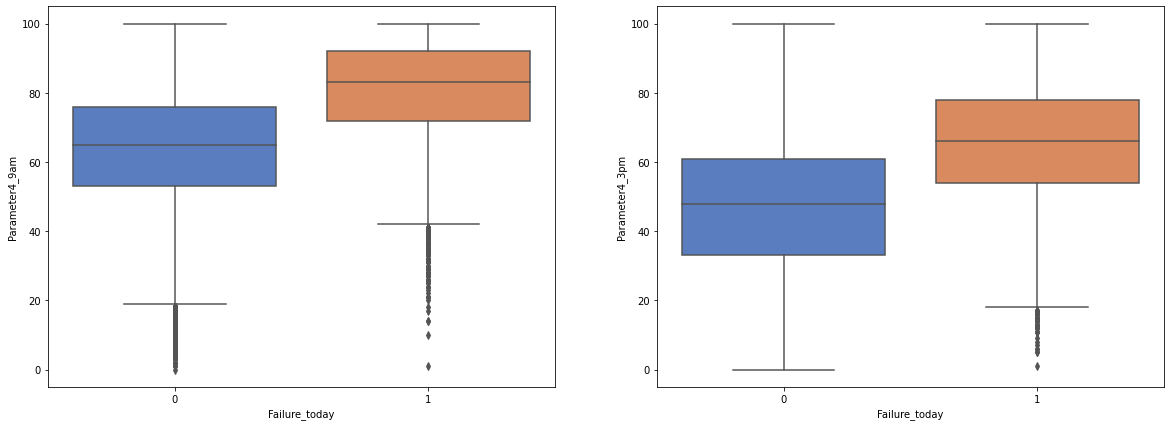

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.boxplot(df,x="Failure_today",y="Parameter4_9am",ax=axes[0])
sns.boxplot(df,x="Failure_today",y="Parameter4_3pm",ax=axes[1])
plt.show()

Podemos ver que claramente, en ambos horarios, hay una diferencia en el valor centrar y los cuartiles cuando falla y cuando no el sensor. Además, durante la mañana el parametro revela un valor levemente mayor que la tarde

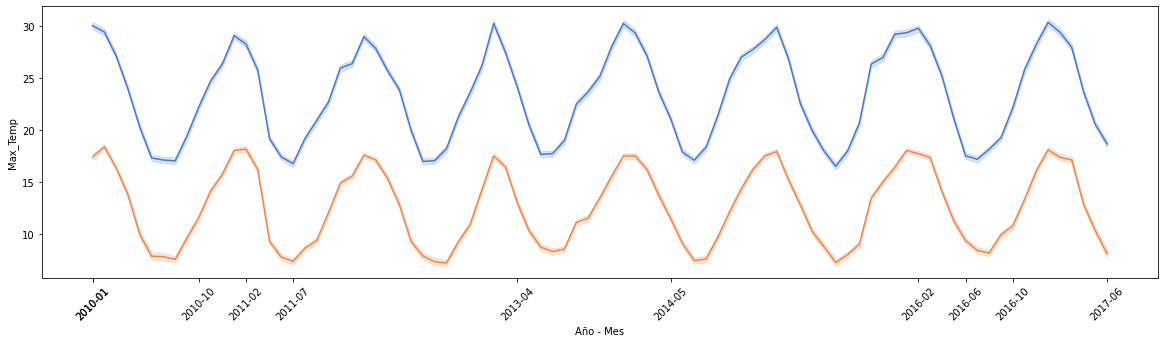

In [132]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x="Año - Mes", y="Max_Temp"); sns.lineplot(data=df, x="Año - Mes", y="Min_Temp")
plt.xticks(df["Año - Mes"][::len(df)//10], rotation=45)
plt.show()

Podemos notar una clara estacionalidad en la temperatura maxima y minima

<Axes: xlabel='Parameter5_9am', ylabel='Density'>

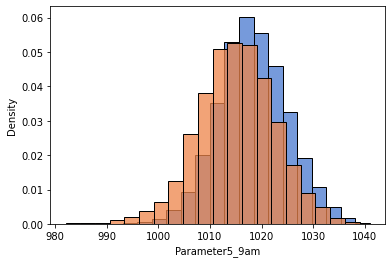

In [99]:
sns.histplot(df[df["Failure_today"]==0],x="Parameter5_9am",stat="density",bins=20)
sns.histplot(df[df["Failure_today"]==1],x="Parameter5_9am",stat="density",bins=20)


Vemos que hay un leve desplazamiento en el parametro 5 cuando falla el sensor

C:\Users\joaqu\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


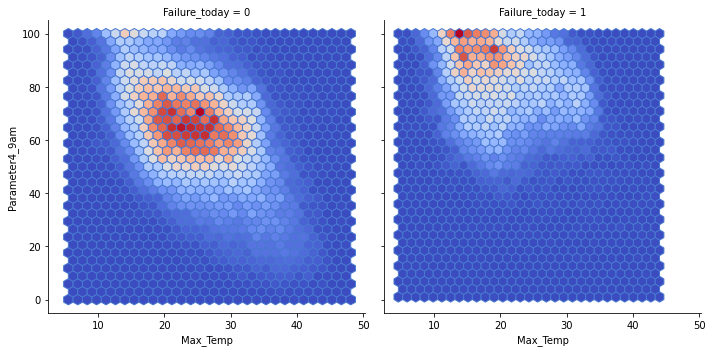

In [100]:
g = sns.FacetGrid(df, col="Failure_today", height=5)
g.map_dataframe(plt.hexbin, x="Max_Temp", y="Parameter4_9am", gridsize=30, cmap="coolwarm")

Este grafico que nos muestra la dependencia de 2 variables y su concentración de datos nos evidencia que, si bien no parece haber una relación entre max temp y el parametro 4, vemos que cuando falla estas 2 variables la concentración de la interacción se desplazan bastante en comparación a cuando no, teniendo una temperatura maxima menor pero un valor de parametro 4 mayor.

In [101]:
df

,Date,Location,Min_Temp,Max_Temp,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Fecha,Año,Mes,Año - Mes
0,2010-01-01,3,19.4,31.9,39.0,N,W,9.0,9.0,70.0,40.0,1012.2,1008.5,23.4,30.9,1,2010-01-01,2010,1,2010-01
1,2010-01-02,3,18.6,29.1,56.0,S,W,6.0,28.0,88.0,48.0,1007.8,1006.2,20.6,28.0,1,2010-01-02,2010,1,2010-01
2,2010-01-03,3,12.2,29.7,30.0,S,S,9.0,19.0,57.0,32.0,1014.4,1012.5,18.0,28.0,0,2010-01-03,2010,1,2010-01
3,2010-01-04,3,14.8,32.8,30.0,E,N,11.0,9.0,55.0,24.0,1017.5,1013.6,21.3,30.6,0,2010-01-04,2010,1,2010-01
4,2010-01-05,3,15.0,35.8,46.0,E,N,4.0,17.0,46.0,13.0,1014.9,1011.5,23.3,34.9,0,2010-01-05,2010,1,2010-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91384,2017-06-20,14,19.3,33.4,35.0,S,N,9.0,20.0,63.0,32.0,1013.9,1010.5,24.5,32.3,0,2017-06-20,2017,6,2017-06
91385,2017-06-21,14,21.2,32.6,37.0,S,S,13.0,11.0,56.0,28.0,1014.6,1011.2,24.8,32.0,0,2017-06-21,2017,6,2017-06
91386,2017-06-22,14,20.7,32.8,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,24.8,32.1,0,2017-06-22,2017,6,2017-06
91387,2017-06-23,14,19.5,31.8,26.0,S,N,9.0,17.0,62.0,58.0,1014.9,1010.7,24.8,29.2,0,2017-06-23,2017,6,2017-06


### Parte 2

#### OLS

In [103]:
y = df["Failure_today"]
X = df.copy()

X2 = X.copy()
X = pd.get_dummies(X, columns=["Location"], prefix=["Location"], prefix_sep='__', drop_first=True)
X = X.drop(columns=["Failure_today", 
                    "Date", 
                    "Año",
                    #"Mes",
                    "Año - Mes",
                    "Fecha"],axis=1)
X = pd.get_dummies(X, columns=["Parameter2_9am",
                               "Parameter2_3pm",
                               "Mes",
                               #"Trimestre"
                               ], prefix_sep='__', drop_first=True)

X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

#fail - c(location) - 1

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     632.4
Date:               jue, 24 abr. 2025   Prob (F-statistic):               0.00
Time:                        20:42:54   Log-Likelihood:                -34482.
No. Observations:               91389   AIC:                         6.910e+04
Df Residuals:                   91322   BIC:                         6.973e+04
Df Model:                          66                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.1858      0.25

Se puede notar que la mayoria de variables seleccionadas son significativas. 

Sobre los sensores, se evidencia que el sensor 4 tiene en promedio un 10% mas de probabilidades de fallar menos que el base, mientras que por el contrario el 6 tiene un 20% menos. Los sensores no significativos como el 30 nos estan indicando que tienen un comportamiento similar al base. Con estos resultados a simple vista podemos concluir que la ubicacion del sensor afecta en su probabilidad de fallo

Por el lado de los parametros, vemos que el parametro 5 se comporta de formas muy opuestas entre mañana y tarde, aumentando la probabilidad de fallo si aumenta su valor durante la tarde, pero disminuyendo la probabilidad casi en la misma proporcion si el aumento se da en la mañana. Por otro lado, el parametro 4 tiene un comportamiento de aumentar la probabilidad de fallo en ambos periodos, pero mucho mas marcado en las mañanas.
Para la temperatura, podemos notar que si aumenta en 1 unidad la temperatura maxima, disminuye en 3% la probabilidad de falla, uno de los impactos mas grandes, lo cual tiene sentido por lo visto en los graficos, que en promedio los sensores cuando fallan tienen una temperatura maxima menor al caso cuando no fallan. El parametro 7 tambien tiene comportamiento opuesto entre mañana y tarde, pero este es atribuible a la temperatura, ya que verificamos con los graficos que representan eso, y con max temp y min temp vimos que tienen efectos opuestos. La diferencia es que, durante la tarde, se comporta muy similar a max_temp, pero durante la mañana si bien tiene el mismo efecto que min_temp de aumentar la probilidad, la magnitud es mucho menor.

Finalmente viendo los efectos por mes, tenemos casos como Febrero, que en comparación con Enero es menos propenso a fallar, por el contrario septiembre aumenta la probabilidad de falla. Esto nos da indicios de estacionalidad en la probabilidad que los sensores detecten una falla.

El caso de la temperatura es interesante, ya que se podria interpretar como si la temperatura tenga relación a la operación de esta maquina, osea que si la temperatura maxima es alta significa que está operando. Es por esto que cuando la temperatura maxima aumenta la probabilidad de fallo baja.

### Parte 3

In [104]:
X = X.drop(columns=[#"Electricity",
                    #"Evaporation",
                    #"Electricity_NaN",
                    #"Evaporation_NaN"
                    ],axis=1)

model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.362559
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                91389
Model:                         Probit   Df Residuals:                    91322
Method:                           MLE   Df Model:                           66
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3317
Time:                        20:54:09   Log-Likelihood:                -33134.
converged:                       True   LL-Null:                       -49582.
Covariance Type:                  HC0   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                28.7943      1.122     25.653      0.000      26.594      30.994
Min_Temp

Para el modelo probit se consiguió un mejor ajuste y resultados muy similares al OLS

Por cada aumento de 1 en la temperatura mínima, la probabilidad de fallo aumenta en 1.57%, mientras que este cambio para la temperatura maxima disminuyedicha probabilidad en 2.99%.

Al igual que en OLS, aumentar la velocidad del viento en 1 unidad aumenta la probabilidad de fallo en un 0.43%, un impacto no tan grande pero significativo. El parametro 5 mantiene su tendencia a aumentar la probabilidad de fallo en las tardes y disminuirlo en las mañanas cuando aumenta en 1 unidad. En general, todo se comporta como en OLS.

Para la dirección del viento, si durante la mañana este se encuentra hacia el sur o el oeste, la probabilidad de fallo aumenta en un 3% en relacion a la ,dirección base que es el este, mientras que durante la tarde no se observan impactos mayores. Cuando el viento corre hacia el norte no nos da significativo, tanto en mañana como en tarde, lo cual nos indica que en ambos casos este se comporta similar a la dirección usada de referencia.


### Parte 4

In [ ]:
model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.360972
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                91389
Model:                          Logit   Df Residuals:                    91322
Method:                           MLE   Df Model:                           66
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3347
Time:                        21:51:25   Log-Likelihood:                -32989.
converged:                       True   LL-Null:                       -49582.
Covariance Type:                  HC0   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.6439      1.987     24.979      0.000      45.749      53.539
Min_Temp

Para el logit, podemos identificar el mismo comportamiento que los 2 modelos anteriores, teniendo un aumento en la temperatura minima de una unidad un impacto en el 1.59% de probabilidad de fallo y en el max_temp una disminucion de 3%. Un cambio fuerte con respecto al modelo probit se da en la dirección del viento sur durante la tarde, que ahora nos da no significativa, lo que nos indica que se comporta de manera similar a la referencia del este, lo cual no ocurria en el modelo probit.

### Parte 5



En los 3 modelos pudimos encontrar resultados bastante similares para la interpretación de las variables, con pequeños cambios en la significancia de algunas de estas, especificamente 

Sobre cual modelo recomendaria, de base se descarta OLS al no ser el adecuado para trabajar con una variable dependiente binaria al no estar acotado para [0,1], aunque obviaramos esto es el que posee un R2 mas bajo entre los 3. Fuera de esto, entre logit y probit se comportan de la misma manera, pero al aprecer logit es mas exigente con la significancia. Este comportamiento más conservador puede ser beneficioso y marcar la diferencia a la hora de hacer interpretaciones precisas. Aun asi ambos modelos son extremadamente similares, por lo que no considero que este factor sea clave para elegir uno por sobre el otro de forma tajante.

Sobre la robustez de las variables, la gran mayoria de estas cumplen con esta caracteristica, al ser significativas y tener impactos similares en todos los modelos. Algunas de estas son max_temp y min_temp, parameter1_speed, los parametros5 y algunas locaciones como la 6 y la 4, por otro lado, algunas de las no robustas son el mes 3 al no ser significativo en ningun modelo o el parameter2_3pm_S, al perder su significancia en el modelo logit.

### Parte 6

#### Tratamiento de datos

In [109]:
X2.drop(columns=["Parameter2_9am", 
                 "Parameter2_3pm", 
                 #"Location"
                  ], inplace=True)

X2 = X2.groupby(["Año", "Mes","Location"]).agg({
    **{col: "mean" for col in ['Min_Temp', 'Max_Temp','Parameter1_Speed',
       'Parameter3_9am', 'Parameter3_3pm', 'Parameter4_9am', 'Parameter4_3pm',
       'Parameter5_9am', 'Parameter5_3pm', 'Parameter7_9am', 'Parameter7_3pm']},
        "Failure_today": "sum"
}).reset_index()

X2["Año - Mes"] = X2["Año"].astype(str) + "-" + X2["Mes"].astype(str).str.zfill(2)

In [110]:
X2

,Año,Mes,Location,Min_Temp,Max_Temp,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Año - Mes
0,2010,1,1,18.060714,30.917857,37.678571,10.857143,17.821429,43.928571,29.750000,1014.175000,1012.471429,22.932143,29.017857,2,2010-01
1,2010,1,3,17.282759,34.420690,43.344828,9.689655,19.275862,49.724138,21.068966,1012.110345,1009.162069,23.110345,32.755172,3,2010-01
2,2010,1,4,21.470000,35.153333,45.966667,18.700000,19.600000,38.566667,26.300000,1008.970000,1005.563333,28.276667,34.110000,5,2010-01
3,2010,1,5,17.373684,30.884211,42.263158,10.473684,17.684211,69.052632,47.263158,1013.215789,1010.289474,22.500000,28.942105,4,2010-01
4,2010,1,6,11.164286,27.246429,47.892857,20.357143,23.142857,58.107143,36.178571,1013.003571,1011.642857,17.835714,25.039286,4,2010-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,2017,6,44,10.726316,18.268421,35.421053,11.368421,12.578947,79.526316,66.894737,1023.984211,1021.800000,13.394737,17.205263,7,2017-06
3307,2017,6,45,4.345000,14.870000,24.800000,6.200000,9.500000,97.300000,67.350000,1028.070000,1025.615000,6.650000,13.735000,3,2017-06
3308,2017,6,47,8.827778,18.661111,37.666667,12.833333,18.222222,84.222222,68.888889,1022.788889,1020.844444,13.455556,17.305556,6,2017-06
3309,2017,6,48,11.655556,17.611111,39.833333,15.888889,20.444444,73.111111,69.111111,1026.083333,1024.116667,14.705556,16.650000,5,2017-06


#### Poisson

In [111]:
X3 = X2.copy()

y = X2['Failure_today']
X2=X2.drop(["Año - Mes",
            "Año",
            "Mes",
            #"Location",
            "Failure_today"
            ], 
            axis=1)
#X2 = pd.get_dummies(X2, columns=["Año - Mes"], prefix=["Año y mes"], prefix_sep='__', drop_first=True)
X2 = pd.get_dummies(X2, columns=["Location"], prefix=["Location"], prefix_sep='__', drop_first=True)

X2=sm.add_constant(X2)
poisson=sm.GLM(y,X2,family=sm.families.Poisson()).fit()
print(poisson.summary())

#0.8101 sin location dummie

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 3311
Model:                            GLM   Df Residuals:                     3261
Model Family:                 Poisson   Df Model:                           49
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7384.9
Date:               jue, 24 abr. 2025   Deviance:                       3484.2
Time:                        22:27:31   Pearson chi2:                 3.11e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8453
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.4213      3.349  

In [118]:
pd.set_option('display.float_format', '{:.2f}'.format)
coef=poisson.params
odds_ratios = np.exp(coef)
odds_ratios = 100*(odds_ratios-1)
odds_ratios

const              27200350779.84
Min_Temp                     5.87
Max_Temp                    -1.48
Parameter1_Speed             5.64
Parameter3_9am              -0.45
Parameter3_3pm              -6.13
Parameter4_9am               3.35
Parameter4_3pm              -0.25
Parameter5_9am              -2.29
Parameter5_3pm               0.40
Parameter7_9am              13.81
Parameter7_3pm             -15.19
Location__3                -12.90
Location__4                  4.24
Location__5                -27.02
Location__6                -34.04
Location__7                -20.38
Location__8                -15.40
Location__9                 -8.37
Location__10               -11.63
Location__11                -4.14
Location__12                -3.21
Location__13               -34.59
Location__14               -33.32
Location__15               -16.13
Location__16               -43.09
Location__18               -35.03
Location__20               -24.33
Location__21               -15.16
Location__22  

Para este modelo evaluaremos la cantidad de fallos del sensor en el mes. Vemos comportamientos similares a los modelos previos, por ejemplo, ante un aumento de 1 unidad en la min_temp, la cantidad de fallos en el sensor durante el mes aumentan en un 5.87% en comparación al caso base. Aquí vemos un comportamiento distinto para los parametros 7, ya que un aumento en 1 unidad en la mañana impacta en un aumento del 13% a la cantidad de fallos, bastante mas que la variable de min_temp. Además, notamos que Max_temp no es significativa, al igual que el parametro 3 en la mañana, los parametros 4, y el 5 en la tarde. Lo que mas incide en la mayoria de casos son la ubicacion de los sensores, los cuales se deben comparar con el sensor base.

### Parte 7

<Axes: xlabel='plambda', ylabel='Count'>

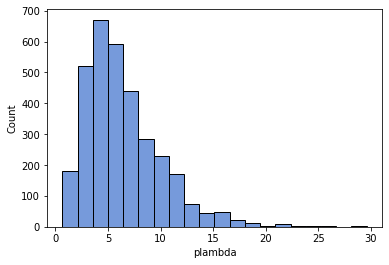

In [119]:
X2['plambda'] = poisson.mu
sns.histplot(data=X2, x="plambda",bins=20)

Podemos ver que hay una "cola larga" en la distribucion

In [120]:
aux=((y-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:          Failure_today   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              3.918
Date:               jue, 24 abr. 2025   Prob (F-statistic):                      0.0479
Time:                        23:01:22   Log-Likelihood:                         -5717.9
No. Observations:                3311   AIC:                                  1.144e+04
Df Residuals:                    3310   BIC:                                  1.144e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [123]:
print(f"El alpha estimado es: {np.exp(-0.0064)}")

El alpha estimado es: 0.993620436379149


Al aplicar la estimación de alpha nos da un valor casi igual a 1, lo que confirma que hay sobredispersión, al no ser cercano a 0

In [124]:
nbin = smf.negativebinomial("Failure_today ~ Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm + C(Location)", data=X3).fit(alpha=1.24)
print(nbin.summary())

c:\Users\joaqu\anaconda3\anaconda\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: alpha. After release 0.14, this will raise.
  warnings.warn(
c:\Users\joaqu\anaconda3\anaconda\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Users\joaqu\anaconda3\anaconda\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Users\joaqu\anaconda3\anaconda\lib\site-packages\scipy\optimize\_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **

         Current function value: 2.230443
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 50


c:\Users\joaqu\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     NegativeBinomial Regression Results                      
Dep. Variable:          Failure_today   No. Observations:                 3311
Model:               NegativeBinomial   Df Residuals:                     3261
Method:                           MLE   Df Model:                           49
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.1976
Time:                        23:02:59   Log-Likelihood:                -7385.0
converged:                      False   LL-Null:                       -9203.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            19.4220      3.352      5.794      0.000      12.852      25.992
C(Location)[T.3]     -0.1373      0.072     -1.907      0.057      -0.278       0.004
C(Location)[T.4]      0.

In [125]:
np.exp(8.499e-05)

1.0000849936117524

Y, al correr una binomial sin especificar alpha, nos entrega su estimación de 8.499e-05, que al aplicarle exponencial nos da aproximadamente 1, un valor similar al que estimamos arriba

### Parte 8

In [126]:
negbin=sm.GLM(y,X2,family=sm.families.NegativeBinomial(alpha=np.exp(-0.0064))).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 3311
Model:                            GLM   Df Residuals:                     3260
Model Family:        NegativeBinomial   Df Model:                           50
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9225.9
Date:               jue, 24 abr. 2025   Deviance:                       763.67
Time:                        23:04:02   Pearson chi2:                     562.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2530
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               30.7950      9.719  

In [127]:
pd.set_option('display.float_format', '{:.2f}'.format)
coef=negbin.params
odds_ratios = np.exp(coef)
odds_ratios = 100*(odds_ratios-1)
odds_ratios

const              2366508221587123.00
Min_Temp                          6.35
Max_Temp                         -3.56
Parameter1_Speed                 11.09
Parameter3_9am                   -0.99
Parameter3_3pm                  -10.98
Parameter4_9am                    5.15
Parameter4_3pm                    0.57
Parameter5_9am                   -4.35
Parameter5_3pm                    1.27
Parameter7_9am                   24.41
Parameter7_3pm                  -20.30
Location__3                     -10.83
Location__4                       5.16
Location__5                     -44.38
Location__6                     -50.80
Location__7                     -27.74
Location__8                     -28.13
Location__9                     -20.42
Location__10                    -20.24
Location__11                      5.23
Location__12                    -15.67
Location__13                    -52.65
Location__14                    -58.63
Location__15                    -30.62
Location__16             

Este modelo tiene un ajuste bastante inferior en comparacion al Poisson, pero con efectos muy similares, por ejemplo, si la min_temp aumenta en una unidad, la cantidad de fallos aumentará en un 6%, y en el caso de la velocidad del viento, una unidad impacta en un 11% a la cantidad de fallos en dicho mes. Al igual que en poisson, muchas variables dieron no significativas, y los cambios mas grandes se ven en la ubicacion de los sensores.

### Parte 9

Al realizar el test de sobredispersión y obtener los resultados de que si existia, podemos descartar automaticamente el modelo poisson, que si bien nos entregaba un buen ajuste este no era adecuado para el problema. Es asi que, al aplicar el poisson, empeoró bastante, lo cual tiene sentido cuando comparamos con los modelos anteriores (Siendo estudios distintos, hace sentido que tengna un comportamiento similar). Además, si bien un modelo no era adecuado, los coeficientes de ambos se comportan similar con leves diferencias. Las variables robustas fueron min_temp, parameter1_speed, parameter3_3p y parameter4_9am entre otros, pero disminuye la cantidad de robustos en comparación al caso estudiado en 2, 3 y 4